In [1]:
import sys
import os

# 1. Get the current directory of the notebook
current_dir = os.getcwd()

# 2. Get the parent directory (project root)
project_root = os.path.dirname(current_dir)

# 3. Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"✅ Added to path: {project_root}")

# 4. Now we import the library
import mylib.data_preprocess as dp
print("✅ Import successful!")

✅ Added to path: /home/alumno/Documents/MLOps/Final-Project-MLOps
✅ Import successful!


⏳ Loading Validation Data...
✅ Data Processed: Train (4225, 30), Val (1409, 30), Test (1409, 30)
📥 Loading Models...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [13:05:12] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator IsotonicRegression from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitat


--- MODEL SELECTION SCORECARD (VALIDATION SET) ---
running XGBoost inference...
   ⏱️ XGBoost Latency: 0.0712 ms/sample
running TabNet inference...
   ⏱️ TabNet Latency: 0.0839 ms/sample

METRIC          XGBOOST         TABNET         
-------------------------------------------------------
ROC-AUC         0.8905          0.8549
Best F1         0.6944          0.6727
Latency (ms)    0.0712          0.0839


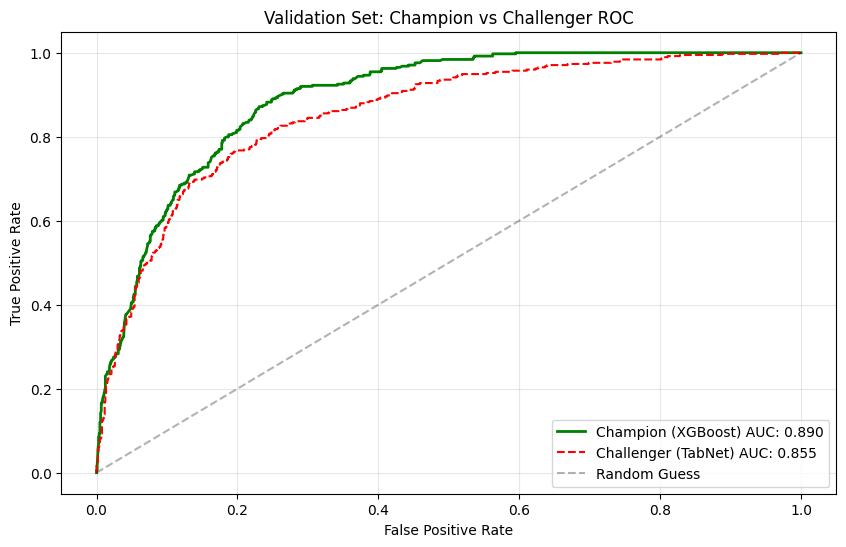


🏆 DECISION: XGBoost selected as CHAMPION.
   Reason: Better AUC
💾 Saved optimal threshold (0.2877) to ../api/models_local/threshold.joblib


In [2]:
import joblib
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from mylib.data_preprocess import get_processed_data

# 1. Load Data
print("⏳ Loading Validation Data...")
X_train, X_val, X_test, y_train, y_val, y_test, _, _ = get_processed_data("../archive/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 2. Load Models
print("📥 Loading Models...")
xgb_model = joblib.load("../api/models_local/model.joblib")
tab_model = joblib.load("../api/models_local/shadow_model.joblib")

# --- HELPER: Find Optimal Threshold ---
def optimize_threshold(y_true, y_probs, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    # F1 = 2 * (P*R)/(P+R)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    ix = np.argmax(f1_scores)
    return thresholds[ix], f1_scores[ix]

# --- HELPER: Measure Inference Time ---
def measure_latency(model, X_input, name, n_loops=10):
    start_time = time.time()
    for _ in range(n_loops):
        _ = model.predict_proba(X_input)
    end_time = time.time()
    
    avg_time_sec = (end_time - start_time) / n_loops
    # Convert to milliseconds per sample
    ms_per_sample = (avg_time_sec / len(X_input)) * 1000
    print(f"   ⏱️ {name} Latency: {ms_per_sample:.4f} ms/sample")
    return ms_per_sample

# ==============================================================================
# XGBoost vs. TabNet (On Validation Set)
# ==============================================================================
print("\n--- MODEL SELECTION SCORECARD (VALIDATION SET) ---")

# 1. XGBoost Metrics
print("running XGBoost inference...")
probs_val_xgb = xgb_model.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, probs_val_xgb)
thresh_xgb, f1_xgb = optimize_threshold(y_val, probs_val_xgb, "XGBoost")
lat_xgb = measure_latency(xgb_model, X_val, "XGBoost")

# 2. TabNet Metrics
print("running TabNet inference...")
probs_val_tab = tab_model.predict_proba(X_val.values)[:, 1]
auc_tab = roc_auc_score(y_val, probs_val_tab)
thresh_tab, f1_tab = optimize_threshold(y_val, probs_val_tab, "TabNet")
lat_tab = measure_latency(tab_model, X_val.values, "TabNet")

# 3. The Scoreboard
print("\n" + "="*55)
print(f"{'METRIC':<15} {'XGBOOST':<15} {'TABNET':<15}")
print("-" * 55)
print(f"{'ROC-AUC':<15} {auc_xgb:.4f}          {auc_tab:.4f}")
print(f"{'Best F1':<15} {f1_xgb:.4f}          {f1_tab:.4f}")
print(f"{'Latency (ms)':<15} {lat_xgb:.4f}          {lat_tab:.4f}")
print("="*55)

# 4. PLOT ROC CURVES
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, probs_val_xgb)
fpr_tab, tpr_tab, _ = roc_curve(y_val, probs_val_tab)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, color='green', linewidth=2, label=f"Champion (XGBoost) AUC: {auc_xgb:.3f}")
plt.plot(fpr_tab, tpr_tab, color='red', linestyle='--', label=f"Challenger (TabNet) AUC: {auc_tab:.3f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set: Champion vs Challenger ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("validation_roc_comparison.png", dpi=300)
plt.show()

# 5. The Decision Logic
if auc_xgb >= auc_tab:
    winner = "XGBoost"
    reason = "Better AUC"
elif lat_xgb < lat_tab:
    winner = "XGBoost"
    reason = "Much faster inference speed"
else:
    winner = "TabNet"
    reason = "Better Performance"

print(f"\n🏆 DECISION: {winner} selected as CHAMPION.")
print(f"   Reason: {reason}")

# Save the Optimized Threshold for the winner
joblib.dump(thresh_xgb, "../api/models_local/threshold.joblib")
print(f"💾 Saved optimal threshold ({thresh_xgb:.4f}) to ../api/models_local/threshold.joblib")

In [3]:
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV

# ==============================================================================
# PHASE 1.5: RETRAIN CHAMPION ON FULL DEV SET (TRAIN + VAL)
# ==============================================================================
print("\n🔄 Merging Train and Validation sets for final retraining...")

# 1. Concatenate Data
X_full_dev = pd.concat([X_train, X_val], axis=0)
y_full_dev = pd.concat([y_train, y_val], axis=0)

print(f"   Original Train shape: {X_train.shape}")
print(f"   Combined Dev shape:   {X_full_dev.shape} (Ready for Champion Training)")

# 2. Extract Best Parameters from the Loaded Model
if hasattr(xgb_model, 'estimator'):
    # It is a CalibratedClassifierCV
    print("   ℹ️ Detected CalibratedClassifierCV. Extracting inner parameters...")
    # 'estimator' is the template used to initialize the calibrated classifier
    best_params = xgb_model.estimator.get_params()
else:
    # It is a raw XGBClassifier
    print("   ℹ️ Detected raw XGBClassifier.")
    best_params = xgb_model.get_params()

# 3. Create a Fresh Model Instance
# We re-instantiate XGBoost with the extracted parameters
base_champion = xgb.XGBClassifier(**best_params)

# 4. Wrap in Calibration (Consistent with our new strategy)
# We recreate the wrapper to ensure we fit on the new full dataset
final_model = CalibratedClassifierCV(estimator=base_champion, method='sigmoid', cv=3)

# 5. Fit on the FULL Development Set
print("⚙️ Retraining on full data (this might take a few seconds)...")
final_model.fit(X_full_dev, y_full_dev)

print("✅ 'final_model' has been retrained on Train + Val.")

# UPDATE the variable 'xgb_model' so the next plotting cells use the new one
xgb_model = final_model


🔄 Merging Train and Validation sets for final retraining...
   Original Train shape: (4225, 30)
   Combined Dev shape:   (5634, 30) (Ready for Champion Training)
   ℹ️ Detected CalibratedClassifierCV. Extracting inner parameters...
⚙️ Retraining on full data (this might take a few seconds)...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [13:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [13:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [13:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ 'final_model' has been retrained on Train + Val.


⚙️ Using Optimized Threshold from previous step: 0.2877

--- 📊 PHASE 2: FINAL ASSESSMENT (TEST SET) ---

--- 📊 GENERATING CONFUSION MATRIX ---
✅ Saved 'confusion_matrix.png'


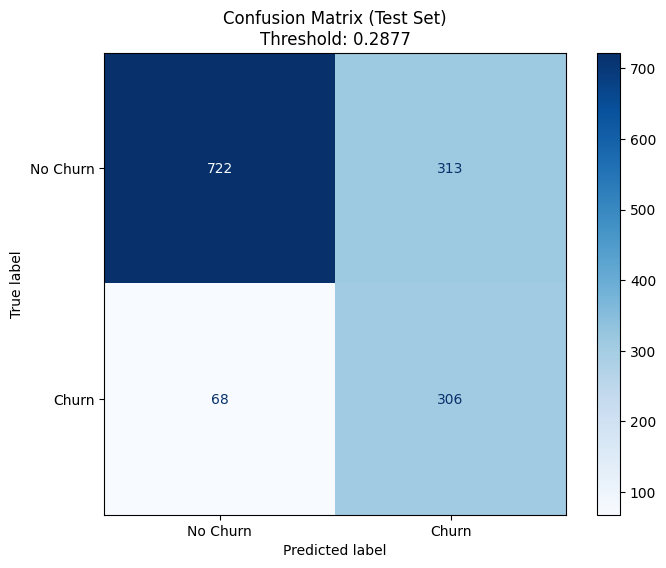


🔧 Fixing SHAP 'Solid Block' artifact...
✅ Saved polished 'shap_summary.png'


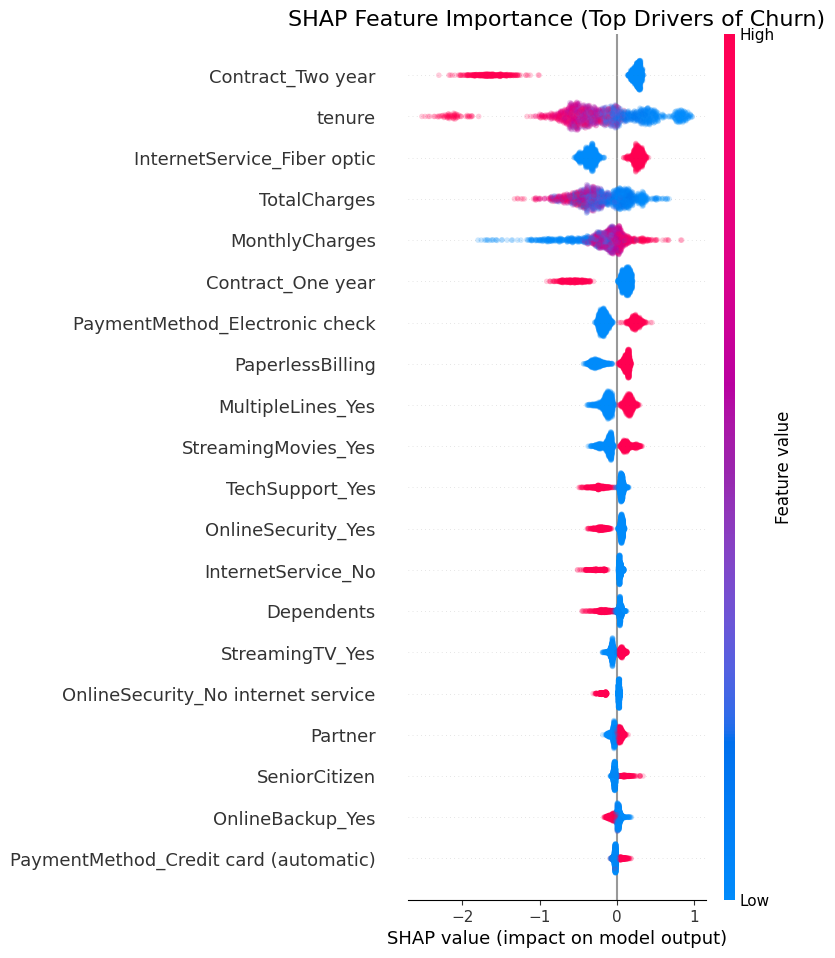

In [4]:
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- CONFIGURATION ---
# Ensure we have the threshold from the previous step
try:
    final_threshold = thresh_xgb
    print(f"⚙️ Using Optimized Threshold from previous step: {final_threshold:.4f}")
except NameError:
    final_threshold = 0.5
    print("⚠️ 'thresh_xgb' not found in memory. Defaulting to 0.5 for plots.")

# ==============================================================================
# PHASE 2: TEST SET
# Now that the winner is chosen, we check how they perform on "Future Data".
# ==============================================================================
print("\n--- 📊 PHASE 2: FINAL ASSESSMENT (TEST SET) ---")

# Generate Test Predictions
probs_test_xgb = xgb_model.predict_proba(X_test)[:, 1]
probs_test_tab = tab_model.predict_proba(X_test.values)[:, 1]


# ==============================================================================
# 1. CONFUSION MATRIX
# ==============================================================================
print("\n--- 📊 GENERATING CONFUSION MATRIX ---")

# Generate Hard Predictions using the Optimized Threshold
probs_test_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_test = (probs_test_xgb >= final_threshold).astype(int)

# Calculate Matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f'Confusion Matrix (Test Set)\nThreshold: {final_threshold:.4f}')
plt.grid(False)

# Save
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
print("✅ Saved 'confusion_matrix.png'")
plt.show()


# ==============================================================================
# FIX 2: SHAP (VISUAL DENSITY)
# ==============================================================================
print("\n🔧 Fixing SHAP 'Solid Block' artifact...")

# 1. UNWRAP THE MODEL
# CalibratedClassifierCV isn't a tree, it's a wrapper. 
# We grab the first internal XGBoost model from the list of calibrated classifiers.
inner_model = xgb_model.calibrated_classifiers_[0].estimator

# 2. Create Explainer using the INNER model
explainer = shap.TreeExplainer(inner_model)
shap_values = explainer.shap_values(X_test)

# Plot with 'alpha'
plt.figure(figsize=(16, 10)) 

# alpha=0.2 makes the dense blobs look like clouds instead of solid bars
shap.summary_plot(shap_values, X_test, alpha=0.2, show=False)

plt.title("SHAP Feature Importance (Top Drivers of Churn)", fontsize=16)
plt.savefig("shap_summary.png", dpi=300, bbox_inches='tight')
print("✅ Saved polished 'shap_summary.png'")
plt.show()


--- 📊 PHASE 2: ROC CURVE COMPARISON ---
   XGBoost Test AUC: 0.8447
   TabNet  Test AUC: 0.8406
✅ Saved 'roc_curve_comparison.png'.


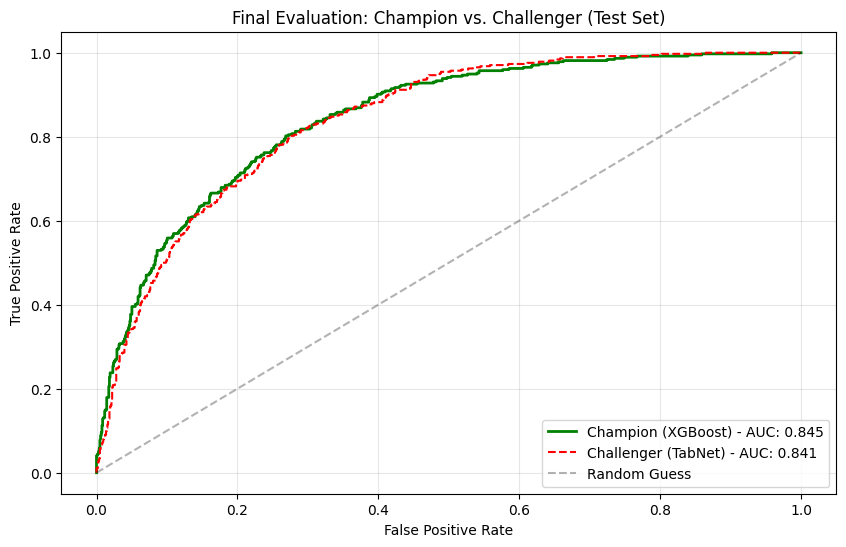

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve


# ==============================================================================
# PHASE 2: FINAL ROC EVALUATION (TEST SET)
# ==============================================================================
print("\n--- 📊 PHASE 2: ROC CURVE COMPARISON ---")

# 1. Generate Test Predictions
probs_test_xgb = xgb_model.predict_proba(X_test)[:, 1]
probs_test_tab = tab_model.predict_proba(X_test.values)[:, 1]

# 2. Calculate AUC Metrics
auc_test_xgb = roc_auc_score(y_test, probs_test_xgb)
auc_test_tab = roc_auc_score(y_test, probs_test_tab)

print(f"   XGBoost Test AUC: {auc_test_xgb:.4f}")
print(f"   TabNet  Test AUC: {auc_test_tab:.4f}")

# 3. Plot ROC Curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, probs_test_xgb)
fpr_tab, tpr_tab, _ = roc_curve(y_test, probs_test_tab)

plt.figure(figsize=(10, 6))

# Plot XGBoost (Green)
plt.plot(fpr_xgb, tpr_xgb, color='green', linewidth=2, 
         label=f"Champion (XGBoost) - AUC: {auc_test_xgb:.3f}")

# Plot TabNet (Red Dashed)
plt.plot(fpr_tab, tpr_tab, color='red', linestyle='--', 
         label=f"Challenger (TabNet) - AUC: {auc_test_tab:.3f}")

# Plot Random Baseline
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label="Random Guess")

# Labels & Saving
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Evaluation: Champion vs. Challenger (Test Set)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.savefig("roc_curve_comparison.png", dpi=300)
print("✅ Saved 'roc_curve_comparison.png'.")
plt.show()


🔧 Generating SHAP Feature Importance...
✅ Saved polished 'shap_summary.png'


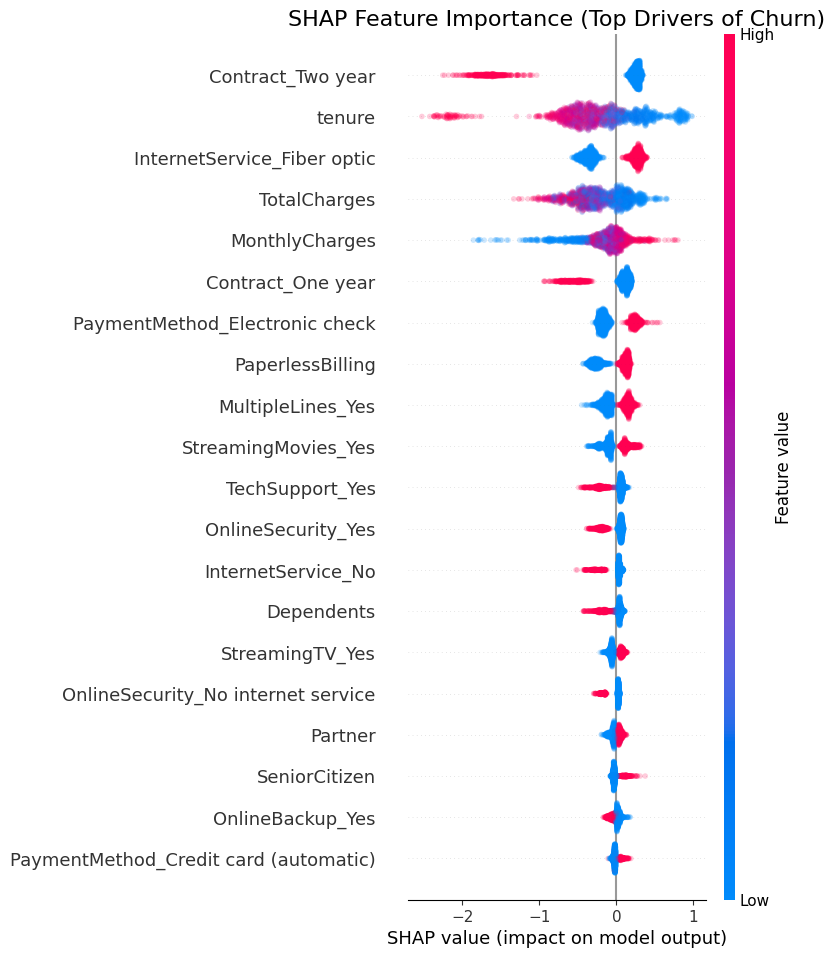

In [6]:
import shap

# ==============================================================================
# PHASE 3: SHAP EXPLAINABILITY
# ==============================================================================
print("\n🔧 Generating SHAP Feature Importance...")

# 1. UNWRAP THE MODEL
# SHAP cannot explain the "Calibrated" wrapper directly.
# We extract the first internal XGBoost model to explain its logic.
inner_model = xgb_model.calibrated_classifiers_[0].estimator

# 2. Create Explainer
explainer = shap.TreeExplainer(inner_model)
shap_values = explainer.shap_values(X_val)

# 3. Plot
plt.figure(figsize=(16, 10)) 

# alpha=0.2 makes the dense blobs look like clouds (better visibility)
shap.summary_plot(shap_values, X_val, alpha=0.2, show=False)

plt.title("SHAP Feature Importance (Top Drivers of Churn)", fontsize=16)

# Save & Show
plt.savefig("shap_summary.png", dpi=300, bbox_inches='tight')
print("✅ Saved polished 'shap_summary.png'")
plt.show()


--- 🎯 CALIBRATION ASSESSMENT (VAL SET) ---
✅ Saved 'calibration_curve_val.png'.


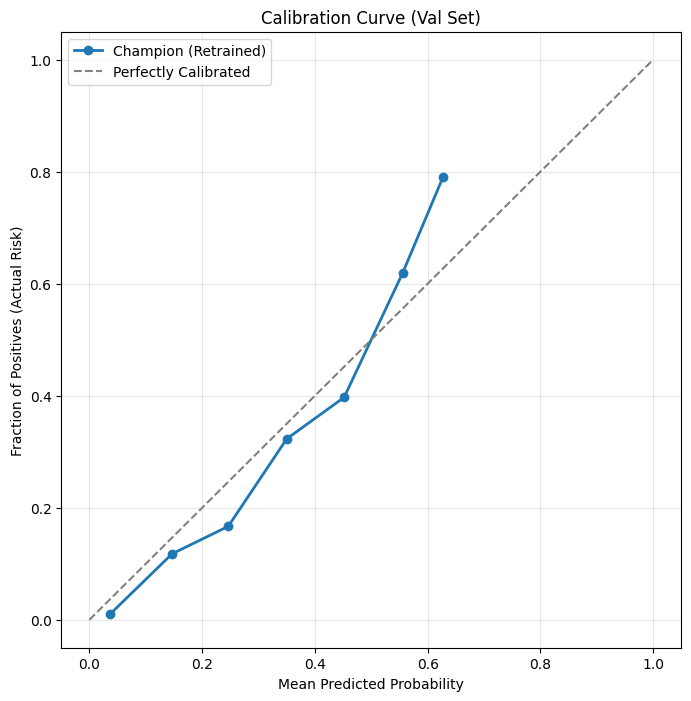

In [7]:
from sklearn.calibration import calibration_curve

# ==============================================================================
# PHASE 2: FINAL VAL SET CALIBRATION CHECK
# ==============================================================================
print("\n--- 🎯 CALIBRATION ASSESSMENT (VAL SET) ---")

# Generate Probabilities on Val Set
# 'xgb_model' is now the one trained on Train + Val
probs_val_xgb = xgb_model.predict_proba(X_val)[:, 1]

# 1. Calculate Calibration Curve points
prob_true, prob_pred = calibration_curve(y_val, probs_val_xgb, n_bins=10)

# 2. Plotting
plt.figure(figsize=(8, 8))

# Plot the Model's curve
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Champion (Retrained)')

# Plot the "Perfect Calibration" line (Diagonal)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Risk)')
plt.title('Calibration Curve (Val Set)')
plt.legend()
plt.grid(True, alpha=0.3)

# Save for Report
plt.savefig("calibration_curve_val.png", dpi=300)
print("✅ Saved 'calibration_curve_val.png'.")
plt.show()

⏳ Loading Models & Data...
✅ Data Processed: Train (4225, 30), Val (1409, 30), Test (1409, 30)
⏱️ Training Times -> XGB: 1.21s | TabNet: 24.25s
⚡ Measuring Latency...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator IsotonicRegression from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator CalibratedClassifierCV from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_227299/1418337377.py:100: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_227299/1418337377.py

✅ Saved 'efficiency_comparison.png'


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


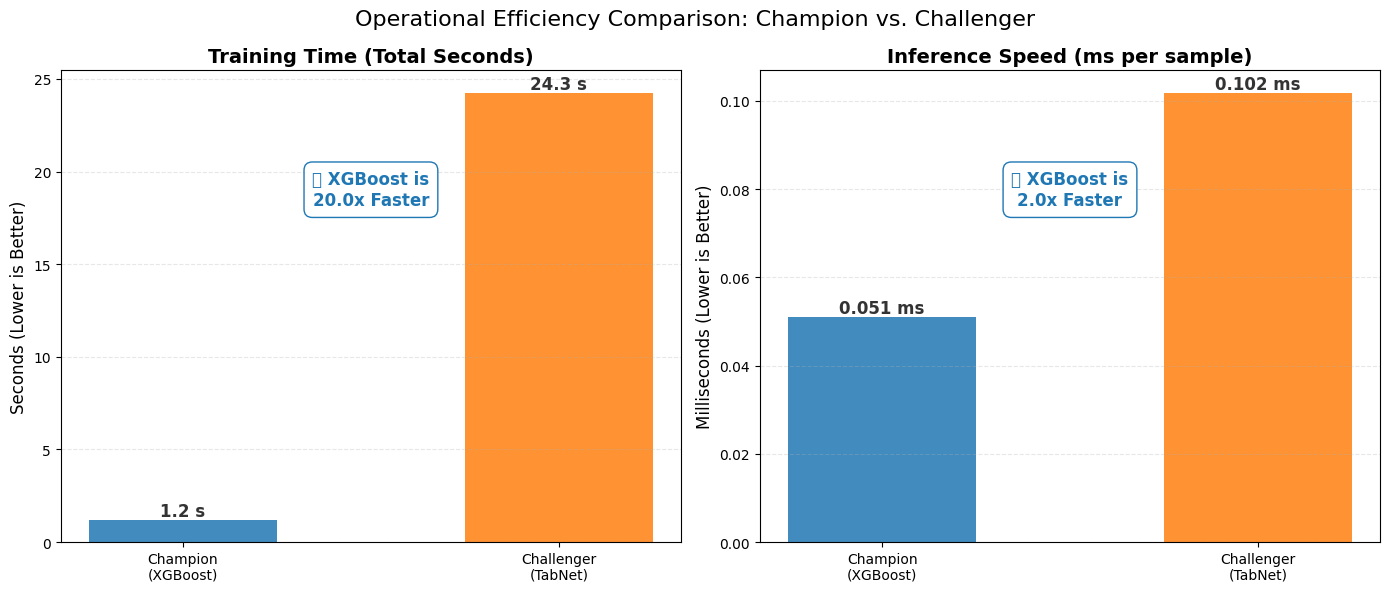

In [8]:
import matplotlib.pyplot as plt
import json
import joblib
import time
import numpy as np
import os
from mylib.data_preprocess import get_processed_data

# 1. Load Data & Models
print("⏳ Loading Models & Data...")
_, _, X_test, _, _, _, _, _ = get_processed_data("../archive/WA_Fn-UseC_-Telco-Customer-Churn.csv")
xgb_model = joblib.load("../api/models_local/model.joblib")
tab_model = joblib.load("../api/models_local/shadow_model.joblib")

# 2. Load Training Times
try:
    with open("../api/models_local/metrics.json", "r") as f:
        data = json.load(f)
        xgb_train_time = data.get("training_time_sec")
except FileNotFoundError:
    print("⚠️ XGB metrics file not found. Using log value.")

try:
    with open("../api/models_local/shadow_metrics.json", "r") as f:
        data = json.load(f)
        tab_train_time = data.get("training_time_sec")
except FileNotFoundError:
    print("⚠️ TabNet metrics file not found. Using log value.")

print(f"⏱️ Training Times -> XGB: {xgb_train_time:.2f}s | TabNet: {tab_train_time:.2f}s")

# 3. Calculate Inference Latency (Live Test)
def get_latency(model, data, is_tabnet=False):
    # Warmup
    input_data = data.values if is_tabnet else data
    _ = model.predict_proba(input_data[:5])
    
    # Measure
    start = time.time()
    _ = model.predict_proba(input_data)
    end = time.time()
    
    return ((end - start) / len(data)) * 1000 # Convert to ms

print("⚡ Measuring Latency...")
xgb_latency = get_latency(xgb_model, X_test, is_tabnet=False)
tab_latency = get_latency(tab_model, X_test, is_tabnet=True)

# --- 4. Plotting the Comparison ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define Colors & Labels
models = ['Champion\n(XGBoost)', 'Challenger\n(TabNet)']
colors = ['#1f77b4', '#ff7f0e'] # Blue vs Orange

# === PLOT 1: Training Time (Lower is Better) ===
train_times = [xgb_train_time, tab_train_time]
bars1 = ax1.bar(models, train_times, color=colors, alpha=0.85, width=0.5)

ax1.set_title('Training Time (Total Seconds)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Seconds (Lower is Better)', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f} s',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333333')

# Training Speedup Annotation
train_speedup = tab_train_time / xgb_train_time
ax1.text(0.5, max(train_times)*0.75, f"🚀 XGBoost is\n{train_speedup:.1f}x Faster", 
         ha='center', fontsize=12, color='#1f77b4', fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='#1f77b4', boxstyle='round,pad=0.5'))


# === PLOT 2: Inference Latency (Lower is Better) ===
latencies = [xgb_latency, tab_latency]
bars2 = ax2.bar(models, latencies, color=colors, alpha=0.85, width=0.5)

ax2.set_title('Inference Speed (ms per sample)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Milliseconds (Lower is Better)', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f} ms',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333333')

# Inference Speedup Annotation
inf_speedup = tab_latency / xgb_latency
ax2.text(0.5, max(latencies)*0.75, f"🚀 XGBoost is\n{inf_speedup:.1f}x Faster", 
         ha='center', fontsize=12, color='#1f77b4', fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='#1f77b4', boxstyle='round,pad=0.5'))

plt.suptitle("Operational Efficiency Comparison: Champion vs. Challenger", fontsize=16)
plt.tight_layout()
plt.savefig("efficiency_comparison.png", dpi=300)
print("✅ Saved 'efficiency_comparison.png'")
plt.show()

In [9]:
import pandas as pd
import numpy as np
import nannyml as nml
import math

# 1. Setup Data
# Reference (Validation)
ref_df = X_val.copy()
ref_df['churn'] = y_val.values
ref_df['y_pred_proba'] = xgb_model.predict_proba(X_val)[:, 1]
ref_df['y_pred'] = (ref_df['y_pred_proba'] >= 0.5).astype(int)

# Analysis (Test)
ana_df = X_test.copy()
ana_df['churn'] = y_test.values
ana_df['y_pred_proba'] = xgb_model.predict_proba(X_test)[:, 1]
ana_df['y_pred'] = (ana_df['y_pred_proba'] >= 0.5).astype(int)

# This ensures NannyML gets exactly equal chunks with NO remainders.
def trim_to_divisible(df, n_chunks=5):
    remainder = len(df) % n_chunks
    if remainder > 0:
        print(f"✂️ Trimming {remainder} rows from {len(df)} to enforce perfect split...")
        return df.iloc[:-remainder] # Drop the tail
    return df

# Apply trim & Shuffle
ref_df = trim_to_divisible(ref_df.sample(frac=1, random_state=42).reset_index(drop=True))
ana_df = trim_to_divisible(ana_df.sample(frac=1, random_state=42).reset_index(drop=True))

print(f"✅ Final Shapes -> Reference: {ref_df.shape} | Analysis: {ana_df.shape}")

# 2. Run NannyML
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='churn',
    metrics=['roc_auc'],
    chunk_number=5, 
    problem_type='classification_binary'
)

print("🧠 Fitting...")
estimator.fit(ref_df)
results = estimator.estimate(ana_df)

# 3. Plot & Save
try:
    fig = results.plot()
    fig.update_layout(title="Continuous Monitoring: Estimated vs. Realized Performance (CBPE)")
    
    fig.write_image("nannyml_cbpe.png", scale=2)
    print("✅ Saved clean chart to 'nannyml_cbpe.png'")
    fig.show()
except Exception as e:
    print(e)
    results.plot().show()

✂️ Trimming 4 rows from 1409 to enforce perfect split...
✂️ Trimming 4 rows from 1409 to enforce perfect split...
✅ Final Shapes -> Reference: (1405, 33) | Analysis: (1405, 33)
🧠 Fitting...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/nannyml/chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/nannyml/chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/nannyml/chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(


✅ Saved clean chart to 'nannyml_cbpe.png'
